In [ ]:
# Step 1: Install required libraries and setup Kaggle
!pip install kaggle librosa tensorflow scikit-learn pandas numpy matplotlib

# Step 2: Upload Kaggle API key (kaggle.json)
from google.colab import files
files.upload()

# Step 3: Configure Kaggle API
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4: Download RAVDESS dataset
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!unzip ravdess-emotional-speech-audio.zip -d ravdess


In [9]:
import librosa
audio_file_path='/content/ravdess/Actor_01/03-01-01-01-01-01-01.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)
print(librosa_audio_data)

[ 5.3765323e-08 -2.1233109e-08 -6.0478840e-09 ...  1.9131086e-15
  4.2487444e-14  5.9047873e-14]


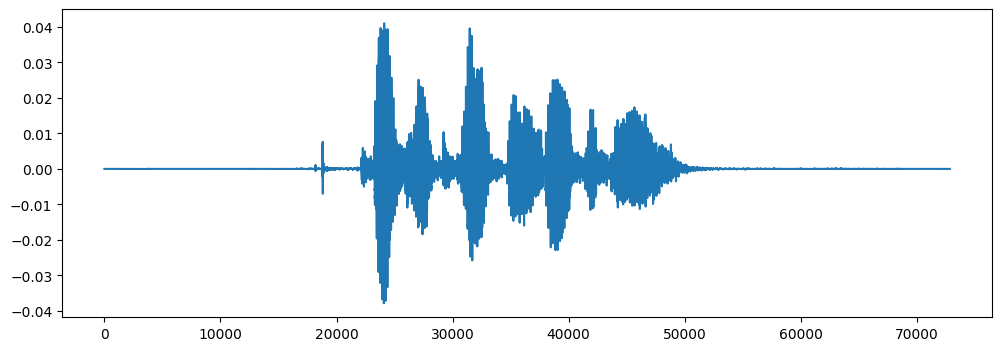

In [10]:
import matplotlib.pyplot as plt
# Original audio with 1 channel
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten


# Function to extract features from audio files
def extract_features(file_path):
    data, sample_rate = librosa.load(file_path, duration=3, offset=0.5)
    mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    return mfccs_scaled

# Prepare dataset
DATA_PATH = 'ravdess/audio_speech_actors_01-24/'
emotions = []
features = []

for root, dirs, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            emotion = int(file.split("-")[2])  # Extract emotion label
            features.append(extract_features(file_path))
            emotions.append(emotion)

# Convert to DataFrame
df = pd.DataFrame(features)
df['label'] = emotions

# Encode labels
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])
df.head()


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,label
0,-501.725372,57.239311,-25.352457,9.914879,2.044111,-13.334452,-0.666273,-13.167732,-2.534130,-5.981103,...,2.490821,3.988022,9.610497,7.344720,5.826166,2.688030,3.566813,4.041529,5.944189,2
1,-619.819702,70.778381,16.628662,12.034029,4.778381,-1.194662,-4.959909,-14.844584,-7.256193,0.513555,...,6.796081,7.249265,11.027343,9.477566,7.964203,5.600621,5.573217,2.667948,5.667860,6
2,-533.483032,53.912521,-5.379925,0.234842,-6.598027,-4.696712,3.314969,-17.314329,-6.640581,-5.614965,...,4.545635,4.528076,4.731555,2.535709,4.314135,2.552447,2.665833,1.417134,3.522739,7
3,-607.591675,61.154598,-11.845322,22.319326,4.487621,-5.201905,-0.349165,-8.826373,-0.999150,-2.382789,...,3.504345,3.512796,5.586878,3.767265,3.323028,1.074884,3.746975,6.132777,8.613084,2
4,-694.996521,76.103996,11.912189,17.987270,10.349314,4.824118,-1.749052,-12.369834,-4.407049,0.796404,...,8.466439,8.888453,13.301257,10.560818,9.091496,2.612953,2.336492,-0.227921,4.183765,3


In [3]:
# Split data into train and test sets
X = df.iloc[:, :-1].values  # Features
y = df['label'].values      # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Build the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          10,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,168 (203.78 KB)

 Trainable params: 52,168 (203.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.1385 - loss: 2.1004 - val_accuracy: 0.1424 - val_loss: 2.0635
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1381 - loss: 2.0672 - val_accuracy: 0.1319 - val_loss: 2.0505
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1740 - loss: 2.0538 - val_accuracy: 0.1632 - val_loss: 2.0277
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1781 - loss: 2.0404 - val_accuracy: 0.2257 - val_loss: 1.9831
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1925 - loss: 1.9926 - val_accuracy: 0.2882 - val_loss: 1.9320
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2385 - loss: 1.9665 - val_accuracy: 0.2396 - val_loss: 1.9068
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2192 - loss: 1.9322 - val_accuracy: 0.2569 - val_loss: 1.8609
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2591 - loss: 1.9029 - val_accuracy: 0.2986 - val_loss

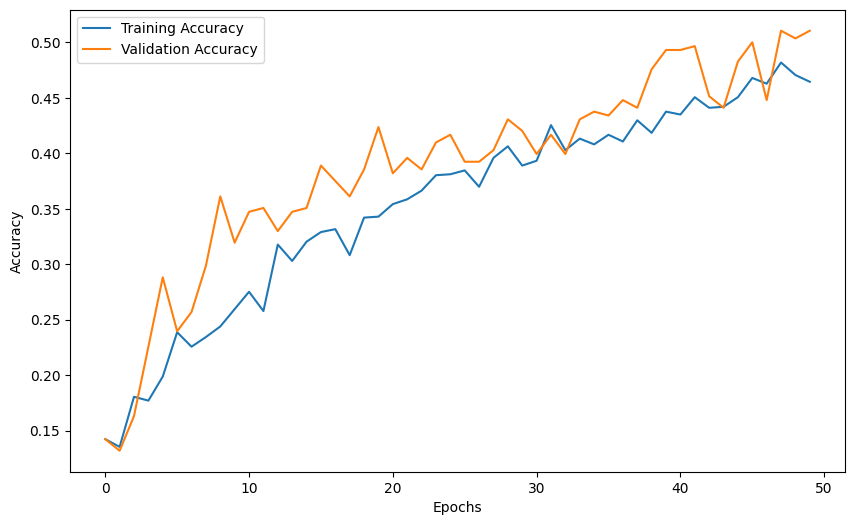

In [4]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [5]:
# # Evaluate on test data
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# # Predict on test data
# y_pred = model.predict(X_test)
# y_pred_labels = np.argmax(y_pred, axis=1)
# y_true_labels = np.argmax(y_test, axis=1)

# # Display classification report
# from sklearn.metrics import classification_report
# print(classification_report(y_true_labels, y_pred_labels, target_names=encoder.classes_))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5109 - loss: 1.3898 
Test Accuracy: 51.04%
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


TypeError: object of type 'numpy.int64' has no len()

In [6]:
from sklearn.metrics import classification_report

# Convert integer labels to string labels
target_names = [str(label) for label in encoder.classes_]

# Print classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=target_names))


              precision    recall  f1-score   support

           1       0.14      0.05      0.07        22
           2       0.33      0.91      0.48        35
           3       0.50      0.30      0.38        33
           4       0.62      0.41      0.49        37
           5       0.86      0.60      0.71        40
           6       0.67      0.61      0.64        46
           7       0.72      0.38      0.50        34
           8       0.47      0.59      0.52        41

    accuracy                           0.51       288
   macro avg       0.54      0.48      0.47       288
weighted avg       0.57      0.51      0.50       288

